In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("C:/Users/Olivier Desclaux/Desktop/Recherche/SLP-Code") #accessing all functions from SLP-Code
from data.SLP_RD import SLP_RD
import cv2
import utils.vis as vis
import os

In [3]:
joints_name = ["Right Ankle", "Right Knee", "Right Hip", "Left Hip", "Left Knee", "Left Ankle", "Right Wrist", "Right Elbow", "Right Shoulder", "Left Shoulder","Left Elbow", "Left Wrist", "Thorax", "Head"]

In [19]:
cov = 'uncover'
class pseudo_opts:
    SLP_fd = 'D:\SLP\simLab' # give your dataset folder here 
    sz_pch=[256, 256]
    fc_depth = 50
    cov_li = [cov]       # give the cover class you want here 
SLP_Reader = SLP_RD(pseudo_opts, phase='test')  # all test result

initializing SLP: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 72.87it/s]


depth
{'Right Ankle': 0.112, 'Right Knee': 0.247, 'Right Hip': 0.089, 'Left Hip': 0.272, 'Left Knee': 0.208, 'Left Ankle': 0.059, 'Right Wrist': 0.093, 'Right Elbow': 0.099, 'Right Shoulder': 0.153, 'Left Shoulder': 0.058, 'Left Elbow': 0.268, 'Left Wrist': 0.023, 'Thorax': 0.061, 'Head': 0.285}

Number of joints with normalized error below 0.5 = 14/14
------------------------------------------------------------


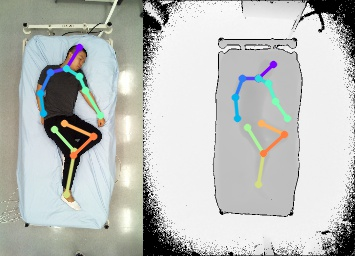

In [31]:
# Info about the image you want to visualise
idx = 241      # the index you want
mods = ['depth']
VERBOSE = True
h = 256 # For resizing
json_dir = 'D:\SLP\jsons'

#  GT in RGB
RGB, jtA, bbA = SLP_Reader.get_array_joints(idx_smpl=idx, mod='RGB')
hA, wA = RGB.shape[:2]
#resize RGB
scal_RGB = h/hA 
RGB_rsz = cv2.resize(RGB, (int(wA * h /hA), h))
# show skel, correct 
jt_RGB_rsz = jtA.copy() *scal_RGB
jt_RGB_rsz[:,2] = 1
RGB_img_skel = vis.vis_keypoints(RGB_rsz[:,:,::-1], jt_RGB_rsz, SLP_Reader.skels_idx)
img_cb = RGB_img_skel

for mod in mods:
    #load json file
    json_path = os.path.join(json_dir,'HRpose_danaLab_'+ mod +'_simLab_' + mod + '_'+ cov +'.json')
    with open(json_path) as json_file:
        outputs = json.load(json_file)  

    # load Predictions
    preds_ori_idx = np.array(outputs['preds_ori'][idx])
    joints_ori_idx = np.array(outputs['joints_ori'][idx])
    l_std_ori_all_idx = np.array(outputs['l_std_ori_all'][idx])
    err_nmd_idx = np.array(outputs['err_nmd'][idx])

    # image in the specific mod
    gt_image, gt_joints, gt_bb = SLP_Reader.get_array_joints(idx_smpl=idx, mod=mod)
    gt_h, gt_w = gt_image.shape[:2] 

    # resize mod
    scale_factor = h/gt_h
    gt_image_rsz = cv2.resize(gt_image, (int(gt_w * scale_factor), h))

    if mod != 'RGB':
        gt_image_rsz_3c = np.stack((gt_image_rsz,)*3, axis=-1) # duplicate the image to 3 channels so it is seen as an RGB image (better for plotting)
    else:
        gt_image_rsz_3c = gt_image_rsz[:,:,::-1]
    # resize joints
    preds_ori_idx_rsz = preds_ori_idx.copy() * scale_factor
    # add ones to the 3D column of the predictions for plotting
    preds_ori_idx_rsz = np.append(preds_ori_idx_rsz, np.ones((len(preds_ori_idx_rsz),1)), 1)

    mod_img_skel = vis.vis_keypoints(gt_image_rsz_3c, preds_ori_idx_rsz, SLP_Reader.skels_idx)
    img_cb = np.concatenate([img_cb, mod_img_skel], axis=1)

    if VERBOSE:
        zip_iterator = zip(joints_name, np.round(err_nmd_idx, 3))
        normalized_errors_dict = dict(zip_iterator)
        print(mod)
        print (normalized_errors_dict)
        print()
        thresh = 0.5
        print('Number of joints with normalized error below {} = {}/14'.format(thresh, np.sum(err_nmd_idx <= thresh)))
        print('------------------------------------------------------------')
vis.ipyth_imshow(img_cb) 

